# Homework 4 

## Group 9 : 

Giulia Scialanga, Theodoros Sofianos, Matteo Zmyslowski

# _Does basic house information reflect house's description?_

### Goal 
Implement two clustering and compare the results. We need to create two datasets and each of them will be filled by data that we scraped.

In [ ]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from nltk import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import inflect
import math
import numpy as np 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
from os import listdir
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import threading


# 1) Scraping 

We select 10.103 announcements from https://www.immobiliare.it . To do this we implement an algorithm that, for each page of the website, opens each announcement and extracts the informations we need. At first we make a get request on the page that contains all the announcements. If the request is success (it has code 200) we create a BeautifulSoup object to parse html page, otherwise we go on with the next page. To access each announcement in that page, we use a find_all operation in order to retrieve all the paragraphs that should contain the links of the announcements. In every paragraph we search < a > tag and we take the link. If the link doesn't appear like 'https://www.immobiliare.it/....' we go on to the next announcement. At this point we make another get request on the announcement's link and if the request is success (it has code 200) we start to parse the announcement. We want to extract from its html page the following informations: prezzo, locali, superficie, bagni, piano and descrizione. Analyzing the html code we notice that:

- some announcements haven't all the informations so we decide to drop them, to do this we extract the content of the < ul > tag with the attribute "class = list-inline list-piped features__list" and then we search the < li > tag which contain the informations. If the we retrieve less then 4 informations or more than 5 informations we drop the announcement;

- some announcements refers to multiple appartaments so we decide to drop them, to do this we extract the content of the < li > tag with the attribute "class = features__price--double". If it is not empty, we drop it;

- some announcements present instead of the price the 'SU' or 'Prezzo su richiesta' value, so we decide to drop them.

To extract the price we parse the content of the < li > tag with the attribute "class = features__price" and we remove the '.' and '€' characters. To extract the description we parse the content of the < div > tag with the attribute "class = description-text".

In order to clean all data we do the following considerations: 

- if the announcement has '5+' "locali" we decide to replace it with '6' value because it has at least 6 locali;

- if the announcement has '3+' "bagni" we decide to replace it with '4' value because it has at least 4 bagni;

- if the announcement is on the top floor ('A') we decide to replace it with '50' value. We choose this high value because we don't know the real floor of the apartment;

- if the announcement is on the ground floor ('T') we decide to replace it with '0' value;

- if the announcement is is on the basement floor ('S') we decide to replace it with '-1' value;

- if the announcement is is on the mezzanine floor ('R') we decide to replace it with '0.5' value.

In the end we append the informations (prezzo, locali, superficie, bagni, piano e descrizione) in two different lists, the first one that contains all the descriptions named "descriptions" and the second one that contains prezzo, locali, superficie and piano named "informations".

We repeat all the previous steps until we retrieve at least 10k announcements.

In [2]:
%%time
print("Inizio elaborazione", time.strftime("%H:%M:%S"))
descriptions = []
informations = []
i = 1
num_req = 0
while len(informations) < 10100:
    if num_req == 100:
        time.sleep(5)
        num_req = 0
    link = requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i))
    if link.status_code != 200:
        print("Richiesta GET pagina fallita")
        continue
    num_req += 1
    soup = BeautifulSoup(link.content, 'lxml')
    features = soup.find_all('p', attrs={'class': 'titolo text-primary'})
    for elem in features:
        row = []
        link = elem.find('a').get('href')
        if 'https://www.immobiliare.it' in link:
            if num_req == 100:
                time.sleep(5)
                num_req = 0
            annuncio = requests.get(link)
            if annuncio.status_code != 200:
                print("Richiesta GET annuncio fallita")
                continue
            num_req += 1
            soup = BeautifulSoup(annuncio.content, 'lxml')
            if (soup.find('li', attrs={'class': 'features__price--double'}) != None): 
                continue
            info = soup.find('ul', attrs = {'class':'list-inline list-piped features__list'})
            if info == None:
                continue
            info = info.find_all('li')
            if len(info) < 4 or len(info) > 5: 
                continue
            if len(info) == 4 and info[-1].get_text() == 'immobilegarantito':
                continue
            price = soup.find('li', attrs={'class': 'features__price'})
            des = soup.find('div', attrs={'class': 'description-text'})
            if des == None or price == None:
                continue
            price = price.get_text().strip()
            price = price.replace('.','').replace('€', '').strip()
            des = des.get_text().strip()
            if price == 'SU' or 'da' in price or 'Prezzo su richiesta' == price:
                continue
            if 'Prezzo diminuito di' in price: 
                price = price[:price.find(' ')]
            row.append(price)
            for tag in info: 
                text = tag.get_text().strip().split()
                if text[0] != 'immobilegarantito': 
                    row.append(text[0])
            row[1] = row[1].replace('5+','6').strip()
            row[3] = row[3].replace('3+','4').strip()
            row[4] = row[4].replace('A','50').replace('R','0.5').replace('T','0').replace('S','-1').strip()
            informations.append(row) 
            descriptions.append(des)
            if len(informations)%1000 == 0:
                print("Elaborati", len(informations), "annunci", time.strftime("%H:%M:%S"))
    i += 1
print("Fine elaborazione", time.strftime("%H:%M:%S"))

Inizio elaborazione 22:37:23
Elaborati 1000 annunci 23:18:03
Elaborati 2000 annunci 23:55:13
Elaborati 3000 annunci 00:33:18
Elaborati 4000 annunci 01:14:21
Elaborati 5000 annunci 01:55:09
Elaborati 6000 annunci 02:37:38
Elaborati 7000 annunci 03:15:56
Elaborati 8000 annunci 04:00:10
Elaborati 9000 annunci 04:39:12
Elaborati 10000 annunci 05:22:58
Fine elaborazione 05:29:31
Wall time: 6h 52min 8s


We create a pandas DataFrame by the list named "informations". 

In [3]:
data_informations = pd.DataFrame(informations)

In [4]:
data_informations = data_informations.rename(columns={0 : "Prezzo", 1 : "Locali", 2 :"Superficie", 3 :"Bagni", 4 :"Piano"})

We notice that the column 'Piano' contains some values '11+' and we decide to replace this value with '12' because this floor it is at least on 12th floor. 

In [5]:
data_informations['Piano'] = data_informations['Piano'].replace('11+', '12')

We decide to save our DataFrame, that contains informations, into csv file because the time execution of scraping is too long to run every time. We work with this csv file.

In [6]:
data_informations.to_csv(path_or_buf="C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/informations.csv", index=False)

In [82]:
data_informations = pd.read_csv("C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/informations.csv")


We show a sample of this dataset.

In [83]:
data_informations.head(10)

,Prezzo,Locali,Superficie,Bagni,Piano
0,225000,2,50.0,1,1.0
1,400000,3,60.0,1,3.0
2,500000,3,89.0,2,3.0
3,574000,4,89.0,2,5.0
4,300000,2,46.0,1,4.0
5,425000,3,72.0,2,4.0
6,669000,5,86.0,2,4.0
7,657000,5,87.0,2,5.0
8,257000,3,61.0,1,1.0
9,325000,2,60.0,1,3.0


In [116]:
for i in range(len(descriptions)):
    with open('descriptions/description'+str(i)+'.txt', 'w') as f:
        f.write("%s\n" % descriptions[i].encode('utf-8'))

In [117]:
descriptions = []
for file in listdir('descriptions'):
    with open('descriptions/'+file, 'r') as f:
        d = f.read()
        descriptions.append(d)

# Pre-processing descriptions. 
## Lower case
The first pre-processing step is to transform our descriptions into lower case. 

## Tokenization
Tokenization refers to dividing the text into a sequence of words or sentences.

## Removing Punctuation and Stop Words
The next step is to remove punctuation and stopwords, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the data.

## Stemming
Stemming refers to the removal of suffices by a simple rule-based approach. For this purpose, it will be used SnowballStemmer from the NLTK library.


In [86]:
class Preprocessing(): 
    def __init__(self,language):
        self.tokenizer = None
        self.stopwords = None
        self.stemmer = None
        self.number_to_words = None
        self.language = language
    
    def setupNltk(self):
        #Lazy initialization of objects needed to preprocess strings
        if self.tokenizer == None:
            self.tokenizer = RegexpTokenizer(r'\w+')
        if self.stopwords == None:
            self.stopwords = set(stopwords.words(self.language))
        if self.stemmer == None:
            self.stemmer = SnowballStemmer(self.language)
        if self.number_to_words == None:
            self.number_to_words = inflect.engine()
    
    def nltkProcess(self, string):
        #Transform all words to lowercase
        string = string.lower()
        #Setup nltk objects to perform preprocessing
        self.setupNltk()
        #Tokenize the string removing puntuactions
        tokens = self.tokenizer.tokenize(string)
        #Create new sentence
        new_sentence = []
        #Scroll through each word and stemming it
        for word in tokens:
            word = self.stemmer.stem(word)
            #exclude the word if it is a stopword
            if not word in self.stopwords:
                #if the word has length greater than one, it has sufficient information
                #value to be added
                if len(word) > 1:
                    new_sentence.append(word)
                #if the word length is equal to one and it is numeric
                #then the string representation of the number is added
                elif word.isnumeric():
                    new_sentence.append(self.number_to_words.number_to_words(word))           
        # return a list of words
        return new_sentence
    
    def nltkCloudProcess(self,string):
        #Transform all words to lowercase
        string = string.lower()
        #Setup nltk objects to perform preprocessing
        self.setupNltk()
        #Tokenize the string removing puntuactions
        tokens = self.tokenizer.tokenize(string)
        #Create new sentence
        new_sentence = []
        #Scroll through each word and stemming it
        for word in tokens:
            #exclude the word if it is a stopword
            if not word in self.stopwords:
                #if the word has length greater than one, it has sufficient information
                #value to be added
                if len(word) > 1:
                    new_sentence.append(word)
                #if the word length is equal to one and it is numeric
                #then the string representation of the number is added
                elif word.isnumeric():
                    new_sentence.append(self.number_to_words.number_to_words(word))           
        # return a list of words
        return new_sentence
        
        
        
        

In [87]:
# We create an object called preprocessing 
preprocessing = Preprocessing('italian')

In [88]:
# Save in descriptions all the processed words of each announcment.
description_preprocessed = descriptions.copy()
for i in range(len(description_preprocessed)):
    description_preprocessed[i] = preprocessing.nltkProcess(description_preprocessed[i])
    

In [89]:
# We create a vocabulary where for all words in the announcements is associated an id. 
vocabulary = {}
i = 0 
for ann in description_preprocessed: 
    for word in ann:
        if word not in vocabulary: 
            vocabulary[word] = i
            i += 1

# Compute the TF - IDF

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency: 

\begin{equation*}
tf-idf(t,d) = tf(t,d) * idf(t)
\end{equation*}


# Compute the TF

In [90]:
# Compute the term frequency of each words in each documents. 
tf = {}
for i in range(len(description_preprocessed)): 
    set_descriptions = set(description_preprocessed[i])
    for j in set_descriptions: 
        if j not in tf: 
            tf[j] = [(i , description_preprocessed[i].count(j))]
        else: 
            tf[j].append((i,description_preprocessed[i].count(j)))
          

# Compute the IDF 

The idf component is computed as: 

\begin{equation*}
idf(t) = log\frac{1 + n{_d}}{1 + df(d,t)} + 1
\end{equation*}

where *nd*  is the total number of documents, and *df(d,t)* is the number of documents that contain term . The resulting tf-idf vectors are then normalized by the Euclidean norm.

In [91]:
n_ads= len(description_preprocessed)
idf = {}
for k in tf: 
    idf[k] = math.log10(n_ads/len(tf[k]))+1

# Compute the TF-IDF

In [92]:
tf_idf = {}
for k in tf:
    for i in tf[k]:
        if k not in tf_idf:
            tf_idf[k] = [(i[0], i[1] * idf[k])]
        else: 
            tf_idf[k].append((i[0], i[1] * idf[k]))

# Execute the Normalization


\begin{equation*}
v_{norm} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v^2_1 + v^2_2 + ... + v^2_n}}
\end{equation*}

In [93]:
# We create a dictionary named ads that has for key the announcements and for values the tf-idf for each word of the announcement. 
ads = {}
norm_tfidf = {}
for k in tf_idf: 
    for j in tf_idf[k]: 
        if j[0] not in ads: 
            ads[j[0]] = j[1]**2
        else: 
            ads[j[0]] += j[1]**2
for word in tf_idf:
    for j in tf_idf[word]: 
        if word not in norm_tfidf: 
            norm_tfidf[word] = [(j[0], j[1]/math.sqrt(ads[j[0]]))]
        else: 
            norm_tfidf[word].append((j[0], j[1]/math.sqrt(ads[j[0]])))            

In [94]:
n_ann = len(description_preprocessed)

In [95]:
# We create an empty matrix in which there are as columns all words in the announcements without duplicates and as rows the announcements. 
m = []
for i in range(n_ann): 
    m.append(np.zeros(len(vocabulary)))

In [96]:
# We insert tf-idf values inside the matrix and to do this we use the id associated to the words in the vocabulary (as a id of columns 
# in m) and the id of announcements (as id of rows in m).
for k in norm_tfidf: 
    for elem in norm_tfidf[k]: 
        m[elem[0]][vocabulary[k]] = elem[1]

We create a pandas DataFrame named data_desc which contains all the tf-idf value of the words found inside the descriptions of the announcements. Each row represents an announcment and each columns represents a word.

In [97]:
data_desc = pd.DataFrame(m, columns = list(vocabulary.keys()))

We decide to save our DataFrame, that contains descriptions, into csv file because the time execution of scraping is too long to run every time. We work with this csv file.

In [32]:
data_desc.to_csv(path_or_buf="C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/descriptions.csv", index=False)

In [9]:
data_desc = pd.read_csv("C:/Users/giuli/Desktop/Algorithmic methods of Data Mining/4 Homework/descriptions.csv")

We show a sample of this dataset.

In [98]:
data_desc.head(10)

,papill,eur,eleg,compless,residenzial,rifinitissim,bilocal,compost,soggiorn,angol,...,atlantic,x99fm3,0686979966,3420996613,02c71a,gualand,prinicipal,gigg,pizziran,ater
0,0.09204,0.049437,0.05476,0.054771,0.050584,0.082964,0.058282,0.031652,0.039180,0.046361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.061715,0.038196,0.045196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.000000,0.00000,0.000000,0.099786,0.000000,0.000000,0.062440,0.077290,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.077653,0.00000,0.000000,0.079454,0.000000,0.000000,0.049717,0.123084,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.073589,0.091090,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.088389,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.029192,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.044383,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.064182,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.056382,0.069792,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering 

This step consists in clustering the house announcements using *K-means++* and choose the optimal number of clusters using the *Elbow-Method*. 

The performance of the original k-means depends heavily on the initialization of centroids. Poor initialization of centroids will produce bad clustering. 

*K-means++* is designed to improve the centroid initialization for k-means. The basic idea is that the initial centroid should be far away from each other. The algorithm starts by randomly choosing a centroid c0 from all data points. For centroid ci, the probability of a data point *x* been chosen as a centroid is proportional to the squares of the distance of *x* to its nearest centroid.

In this way, k-means++ always tries to select centroids that are far away from the existing centroids, which leads to significant improvement over k-means with a bit sacrifice on the run time.

To choose the optimal numer of clusters we use the Elbow-Method: we should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. The number of clusters is chosen at this point, hence the "elbow criterion". We choose the optimal number of cluster where we see the "elbow" in our plot. 

In [19]:
info_means = []
for k in range(1,20):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_informations)
    info_means.append(kmeans.inertia_)

We observe that in our plot the "elbow" highlights as 4 the optimal number of cluster. 

C:\Users\giuli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


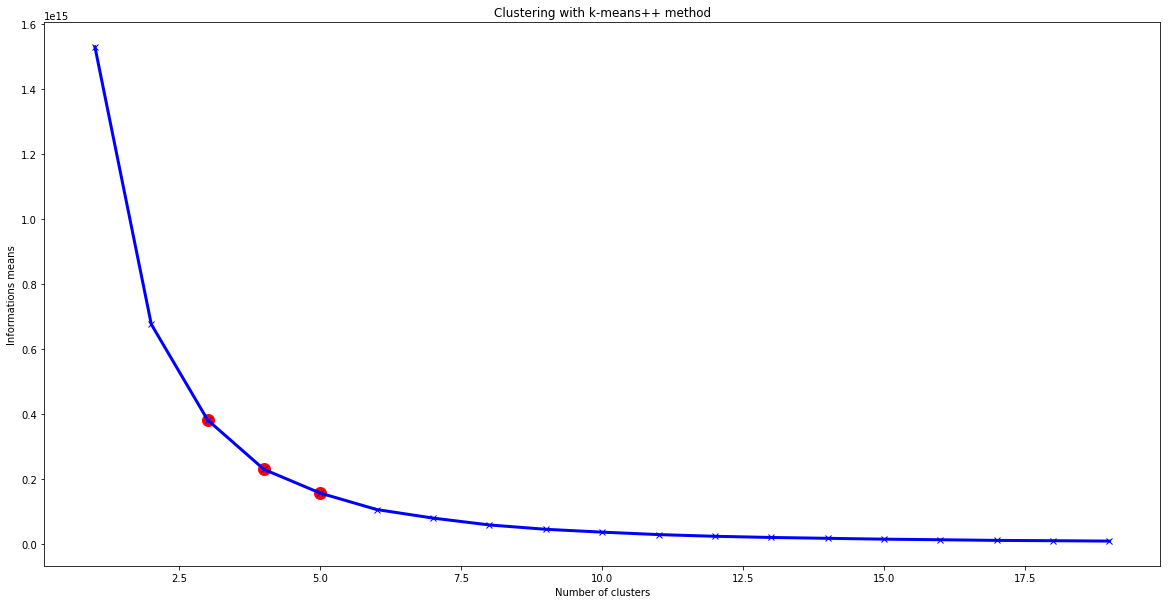

In [20]:
x = range(1,20)
y = info_means
bold = slice(2, 5)
fig = plt.figure(figsize=(20,10))
plt.plot(range(1,20), info_means, "bx-", linewidth = 3.0)
ax = fig.add_subplot(1,1,1)
ax.scatter(x[bold], y[bold], edgecolors='r', linewidths=7)
plt.xlabel('Number of clusters')
plt.ylabel('Informations means')
plt.title('Clustering with k-means++ method')
plt.show()

Using the Elbow method we can observe that the optimal number of clusters is 4. 

In [21]:
#We compute the K-means ++ for 5 clusters (that is the number of optimal cluster)
for k in range(1,6):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_informations)

In [22]:
labels = kmeans.labels_

We create a dictionary named "informations_labels" that has as keys the number of optimal cluster and as values a list of indices of announcements refears to informations.  

In [23]:
informations_labels = {}
for i in range(len(labels)): 
    if labels[i] not in informations_labels: 
        informations_labels[labels[i]] = [i]
    else: 
        informations_labels[labels[i]].append(i)

We perform the previous analysis for the matrix of decriptions. 

In [24]:
%%time
des_means = []
for k in range(1,20):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_desc)
    des_means.append(kmeans.inertia_)

Wall time: 3h 2min 31s


We save the list named des_means inside a txt file. 

In [25]:
with open('des_means.txt', 'w') as f:
    for item in des_means:
        f.write("%s\n" % item)

In [26]:
des_means = []
with open('des_means.txt', 'r') as f:
    for value in f:
        des_means.append(float(value.strip()))

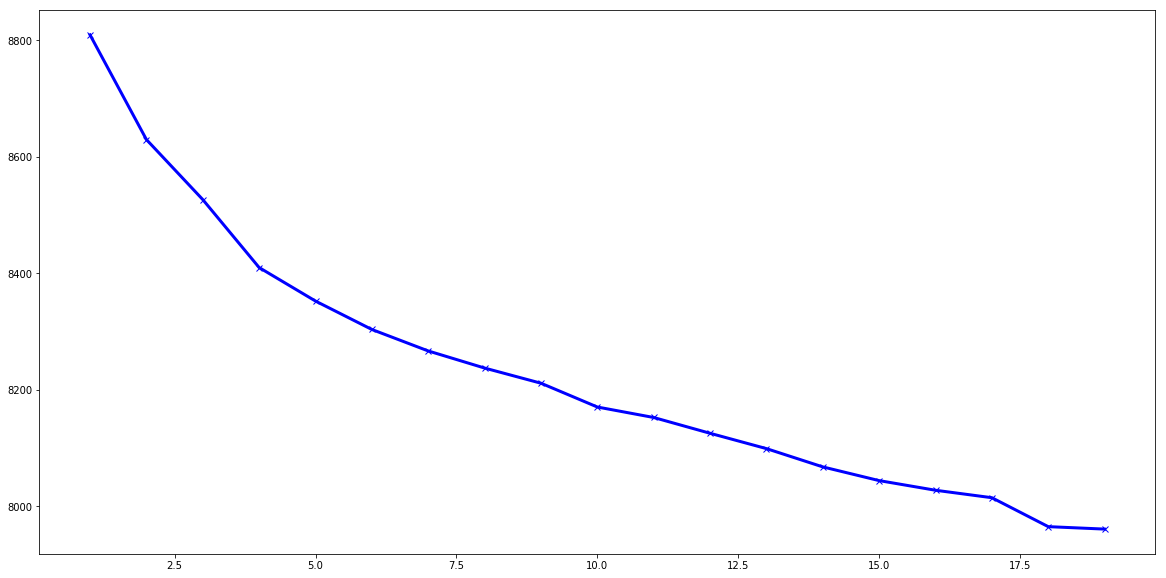

In [27]:
fig = plt.figure(figsize=(20,10))
plt.plot(range(1,20), des_means, "bx-", linewidth = 3.0)
plt.show()

We notice the optimal number of clusters it's too high to be performed. The previous plot shows a sample with at most 20 clusters. For this reason we decide to choose 6 optimal number of clusters in order to compare clusters with Jaccard-similarity. 

In [28]:
for k in range(1,6):
    kmeans = KMeans(n_clusters= k, random_state=0)
    kmeans = kmeans.fit(data_desc)

In [29]:
labels = kmeans.labels_

We create a dictionary named "des_labels" that has as keys the number of optimal cluster and as values a list of indiced of announcements refears to descriptions. 

In [30]:
des_labels = {}
for i in range(len(labels)): 
    if labels[i] not in des_labels: 
        des_labels[labels[i]] = [i]
    else: 
        des_labels[labels[i]].append(i)

# Find similar clusters

## To check this, use the Jaccard-Similarity to measure the similarity betweeen the two outputs (information clusters vs description clusters). Return the 3-most similar couples of clusters.

The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient (originally coined coefficient de communauté by Paul Jaccard), is a statistic used for comparing the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:


\begin{equation*}
J(A,B) = \frac{|A \cap B|}{|A \cup B|}
\end{equation*}

with 


\begin{equation*}
0 <= J(A,B) <= 1
\end{equation*}

The goal of our analysis is to find the 3-most similar couples of clusters (highest Jaccard-similarity values).  

In [31]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(set(list2)))
    union = len(set(list1).union(set(list2)))
    return float(intersection / union)

In [32]:
# Jaccard distance 
jaccard = []
for i in informations_labels: 
    for j in des_labels: 
        jaccard.append(jaccard_similarity(informations_labels[i], des_labels[j]))     

In [33]:
# We print all the clusters's couple with the respective Jaccard similarity. 
for i in range(len(jaccard)):
    print("("+str(i//5)+", "+str(i%5)+") =", jaccard[i])

(0, 0) = 0.31727451946771806
(0, 1) = 0.15964818763326227
(0, 2) = 0.28755737501550677
(0, 3) = 0.10533497066448357
(0, 4) = 0.016816303263502922
(1, 0) = 0.16704588547591961
(1, 1) = 0.10827347698856078
(1, 2) = 0.1686
(1, 3) = 0.086558975921975
(1, 4) = 0.011677695601401323
(2, 0) = 0.05190311418685121
(2, 1) = 0.043738489871086556
(2, 2) = 0.04865727200212709
(2, 3) = 0.03414028553693358
(2, 4) = 0.00430416068866571
(3, 0) = 0.009247027741083224
(3, 1) = 0.008259911894273128
(3, 2) = 0.013872832369942197
(3, 3) = 0.007371007371007371
(3, 4) = 0.011494252873563218
(4, 0) = 0.0024180548092423426
(4, 1) = 0.0034562211981566822
(4, 2) = 0.0017579841781423966
(4, 3) = 0.0
(4, 4) = 0.0


In [34]:
#We make a copy of the jaccard list and then we sort it to extract the 3-most similar couples of clusters with the 3 highest values
jac = jaccard.copy()
jac.sort(reverse = True)

In [35]:
# We find the 3-most similar couples of clusters
max_j = []
for i in range(3):
    idx = jaccard.index(jac[i])
    max_j.append((idx//5, idx%5))

In [36]:
#We observe that the 3-most similar couples of clusters are:
max_j

[(0, 0), (0, 2), (1, 2)]

In [37]:
# In this part of code we obtain all the indeces that refears to the descriptions's announcements 
cloud = []
for i in max_j: 
    cloud.append(list(set(informations_labels[i[0]]).intersection(set(des_labels[i[1]]))))

In [38]:
# We create an object called preprocessing 
preprocessing_cloud = Preprocessing('italian')

In [39]:
# Save in descriptions all the processed words of each announcment.
cloud_preprocessed = descriptions.copy()
for i in range(len(cloud_preprocessed)):
    cloud_preprocessed[i] = preprocessing_cloud.nltkCloudProcess(cloud_preprocessed[i])

In [105]:
# In this way we obtain a string named "string_cloud" with all descriptions. These decriptions have as indices the same indices 
# that we have inside the cloud list i.e. the announcements's indices of the 3-most similar couples of clusters.
string_cloud = ''
count=0
for i in cloud_preprocessed:
    for j in i:
        if j[0]!='x': #
            string_cloud += j+" "

# _Word cloud of house descriptions_

WordCloud is a technique to show which words are the most frequent among the given text.

In [107]:
def transform_format(val):
    if val.all == 0:
        return 255
    else:
        return val.all()

In [108]:
cloud_mask = np.array(Image.open("alien.png"))

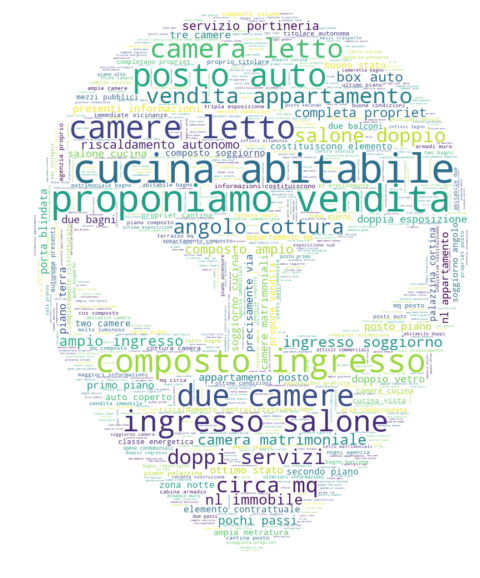

In [109]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=10000, mask = cloud_mask,
               stopwords= STOPWORDS)

# Generate a wordcloud
wc.generate(string_cloud)

# store to file
wc.to_file("wordcloud.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2) Find the duplicates!

First, we created a code for finding duplicates and false positives, when the order of the characters in every password IS NOT important

In [3]:
import threading


In [4]:
NUM_OF_LINES=10000000

Since the file is too big for our computer resources, we decided to split it in parts, where each and one of them will include 10000000 lines-passwrods

In [ ]:
with open("passwords2.txt",'r') as file:
    output = open("output1.txt","w")
    for i,line in enumerate(file):
        output.write(line)
        if i%NUM_OF_LINES == 0:
            output.close()
            output = open("output%d.txt"%(i/NUM_OF_LINES+1),"w")

    output.close()

Our hashing function below does this: For every  a password(we used strip() to remove the \n), it returns the sum of the unicode numbers of every character in the 5th power.For our sizes of passwords, this sum will be a quite big number

In [6]:
def hash_sort(line):
    sums = 0
    for character in line.strip():
        sums+= ord(character)**5
    return sums
        

The following function reads a specific sub-file of the original one and a set and appends to this set the sorted characters of every password-line.Practically, in the end of the for loop, we will have added just the unique passwords of the file. It also returns this set, so it can be updated.(see below for explanation)

In [7]:
def get_duplicates(i,not_dup):
    
     with open('output'+str(i) + '.txt', 'r') as file: #buffering=2000000
            for line in file:
                not_dup.add(''.join(sorted(line.strip())))
            return not_dup

We will use the above function in the code listed below. The original set is obviously an empty one, and inside the for loop, that reads all the sub-files of the original one. We used the return function above, so that the set is updated for every loop.We also used threads, in order to make this code more fast and efficient, since we are expecting to add a huge number of sorted passwords to the set.After the loop is finished, what we get is the unique passwords for the whole original file.

In [5]:
not_dup = set()
Threads = []
for i in range(1,12):
    t = threading.Thread(name = i,target = get_duplicates,args = (i,not_dup))
    Threads.append(t)
    t.start()

Now, to find the exact number of duplicates in the file it's easy. We know that we splitted the original files in 11 parts, all of them having the same number of passwords(NUM_OF_LINES). We also verified that the last part has the same size as well.In order to find the number of duplicates, we simply substract from the overall number of passwords the number of unique passwords

In [11]:
duplicates = NUM_OF_LINES*11 -len(not_dup)

In [7]:
duplicates

10000000

So we can confirm that the number of duplicates is 10M.

In order to find the number of false positives, we will use our hashing function written above. The logic is the same. Create a set and append. Only difference is that now we will append the hashing value and not the password.

In [13]:
def get_duplicates_fp(i,not_dup_fp):
    
     with open('output'+str(i) + '.txt', 'r') as file: #buffering=2000000
            for line in file:
                not_dup_fp.add(hash_sort(line))
            return not_dup_fp
                    

In [5]:
not_dup_fp = set()
Threads = []
for i in range(1,12):
    t = threading.Thread(name = i,target = get_duplicates_fp,args = (i,not_dup_fp))
    Threads.append(t)
    t.start()

Now, we have the set which containts the unique hashing values, so its easy to find the number of duplicates and false positives combined

In [ ]:
duplicates_fp = NUM_OF_LINES*11 - len(not_dup_fp)

In [16]:
print((10000000*11)-len(a)) # since this function happened in another notebook,with other variable names, we thought it's not a great idea running it again.
# In our case, a = not_dup_fp

13749014


So,now we have the number of duplicates and the number of duplicates combined. In order to find the false positives, we just substract.

In [2]:
fp

3749014

# Now, we follow a similar approach, but this time the order of characters in string IS important

Practically, the only difference is the hashing function.The idea is similar as before, but now the unicode numbers of each character of every password are added as strings, so the order is important. Instead of 5th power like before, we used 2nd power in order to get a big number but not a really huge one, for purposes of time saving during the running of the code.

In [1]:
def hash_nosort(line):
    sums = ''
    for character in line.strip():
        sums+= str(ord(character)**2)
    return sums
        

In [2]:
def get_duplicates(i,not_dup):
    
     with open('output'+str(i) + '.txt', 'r') as file: #buffering=2000000
            for line in file:
                not_dup.add(line.strip())
            return not_dup

In [ ]:
not_dup = set()
Threads = []
for i in range(1,12):
    t = threading.Thread(name = i,target = get_duplicates,args = (i,not_dup))
    Threads.append(t)
    t.start()

Above, you can see the number of 'identical' duplicates password, meaning that the order of characters is now taken into account, in order to claim that the passwords are duplicates or not.

In [4]:
def get_duplicates_fp(i,not_dup_fp):
    
     with open('output'+str(i) + '.txt', 'r') as file: #buffering=2000000
        for line in file:
            not_dup_fp.add(hash_nosort(line))
        return not_dup_fp

In [ ]:
duplicates_nosort = NUM_OF_LINES*11 -len(not_dup)

In [ ]:
duplicates_fp_nosort = NUM_OF_LINES*11 - len(not_dup_fp)

In [ ]:
false_positives_nosort = duplicates_fp_nosort-duplicates_nosort